# Packages

In [1]:
using MPOFuncs, ITensors, Integrals, BenchmarkTools, Plots, QuantumOptics, LinearAlgebra, Interpolations, DifferentialEquations, Metal

In [2]:
using JLD2

# To Do 


- Add comments explaining stuff
- combine swap and beamsplitter into one function
- Maybe not destroy the original MPO when taking a projection ✅
- Finally actually check if we are getting the excpected state (bell state of sorts)✅(we are)
- write out measuring the stabalisers
- think about how to add noise cavities ✅


When with a simple just beamsplitter case, the partial trace multiplies in the probability of the projection into the density matrix
<br/> (Confirming what we already knew)

#Doubt if opsum works for diff dimensions for atom and cavities

# Running Cash Karppe Distinguishability graph

In [3]:
# g34_list10 =  [;]
gamma = 1
no_cavs = 2
dt = 0.02
t_final = 10
dep=0.0125
println(dep)
@time mpo, sites = MPOFuncs.cash_karppe_evolve(no_cavs, dep, gamma, dt, t_final)
println(MPOFuncs.trace(mpo,sites))


0.0125
  8.716430 seconds (30.84 M allocations: 12.030 GiB, 4.87% gc time)
1.0 - 2.3229552548472798e-17im


In [42]:
@time double, double_sites = n_copy_mpo(2, mpo, sites)
# println(double, double_sites)
println(trace(double, double_sites))

  0.033033 seconds (58.57 k allocations: 33.128 MiB, 0.76% compilation time)
1.000000000000001 + 1.2803803167803232e-16im


In [43]:
for i=1:no_cavs
    @time beamsplitter!(double, i, i+no_cavs, double_sites)
    println(maximum(maximum.(dims.(double))))
    # println(trace(double, double_sites))
end
println(trace(double, double_sites))

  6.322048 seconds (133.55 k allocations: 1.563 GiB, 1.09% gc time)
72
 98.733702 seconds (137.34 k allocations: 17.016 GiB, 1.51% gc time)
170
204.191469 seconds (138.99 k allocations: 44.594 GiB, 2.53% gc time)
238
350.204719 seconds (139.78 k allocations: 79.919 GiB, 3.12% gc time)
291
654.628355 seconds (140.59 k allocations: 122.754 GiB, 2.27% gc time)
358
1081.818700 seconds (141.29 k allocations: 173.817 GiB, 1.61% gc time)
418
1610.987631 seconds (142.36 k allocations: 221.198 GiB, 1.21% gc time)
493
2258.536085 seconds (143.31 k allocations: 268.777 GiB, 0.97% gc time)
576
3037.045225 seconds (144.45 k allocations: 306.785 GiB, 0.82% gc time)
668
3263.293424 seconds (145.20 k allocations: 301.731 GiB, 0.82% gc time)
677
1.0000000105900537 + 2.228137481670171e-9im


In [44]:
# g_val = g_34(double, double_sites, no_cavs)
g_val2 = g_34(double, double_sites, no_cavs)

0.021668725278591972 + 1.4004180773614257e-9im

In [49]:
f = jldopen("Data/g5.jld2", "r")
g34_list5 = f["g34_list5"]
close(f)
f = jldopen("Data/g5_pt2.jld2", "r")
g34_list5_2 = f["g34_list5"]
close(f)

In [50]:
length(g34_list5)

13

In [55]:
(g34_list5_2)

Any[]

In [52]:
id_lidt = [2*i/(1+4*i) for i=0:0.0025:0.03]
length(id_lidt)

13

In [58]:
g34_list5[5] - g_val

-0.004120815801386981 - 6.990767012588133e-11im

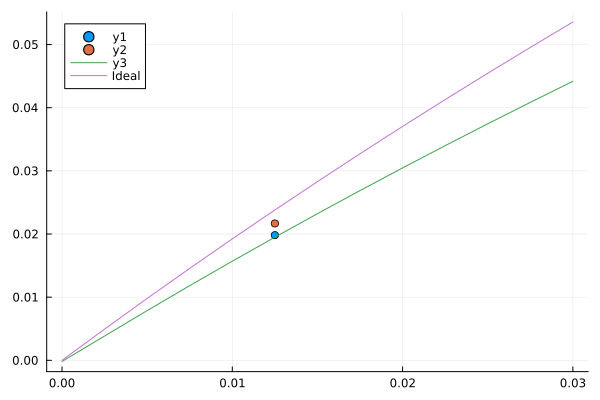

In [57]:
plot([dep,], [real(g_val),], seriestype="scatter")
plot!([dep,], [real(g_val2),], seriestype="scatter")
plot!([0:0.0025:0.03;], real(g34_list5))
plot!([0:0.0025:0.03;], id_lidt, label="Ideal")

In [47]:
(g_val - (2*0.0125/(1+4*0.0125)))/(2*0.0125/(1+4*0.0125))

-0.16757327213073103 - 1.0448349441310567e-9im

In [27]:
g34_list10 =  [;]
gamma = 1
no_cavs = 10
dt = 0.02
t_final = 10
for dep=0.0025:0.0025:0.02
    println(dep)
    mpo, sites = cash_karppe_evolve(no_cavs, dep, gamma, dt, t_final)
    double, double_sites = n_copy_mpo(2, mpo, sites)
    for i=1:no_cavs
        beamsplitter!(double, i, i+no_cavs, double_sites)
    end
    push!(g34_list10, g_34(double, double_sites, no_cavs))
end

0.0025
0.005
0.0075
0.01


InterruptException: InterruptException:

In [28]:
g34_list10

3-element Vector{Any}:
 0.004323277683380037 - 3.7406660248130794e-10im
 0.008786906182112381 + 1.6320178080264148e-9im
 0.013164002041670198 + 1.5277913194127922e-9im

In [95]:
# f = jldopen("g3.jld2", "r")
# g34_list3old = f["g34_list3"]
# close(f)

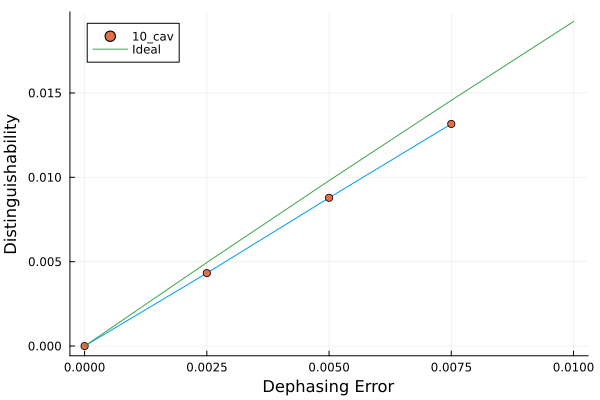

In [31]:
# p = plot([0:0.0025:0.01;], append!([0.0,],real(g34_list10[1:end-1])), label="")
# plot!([0:0.0025:0.01;], append!([0.0,],real(g34_list10[1:end-1])),  seriestype="scatter", label="Truncated Simulation")

p = plot([0:0.0025:0.0075;], append!([0.0,],real(g34_list10[1:end])), label="")
plot!([0:0.0025:0.0075;], append!([0.0,],real(g34_list10[1:end])),  seriestype="scatter", label="10_cav")

# plot!([0.0025:0.0025:0.02;], real(g34_list8), label="8 cav")
# plot!([0.0025:0.0025:0.02;], real(g34_list8), seriestype="scatter")
# plot!([0.0025,], real(g34_list3old), seriestype="scatter")
plot!([0:0.0025:0.01;], [2*i/(1+4*i) for i=0:0.0025:0.01], label="Ideal")
plot!(xlabel="Dephasing Error", ylabel="Distinguishability")
# Plots.pdf(p, "Indistinguishability_plot.pdf")

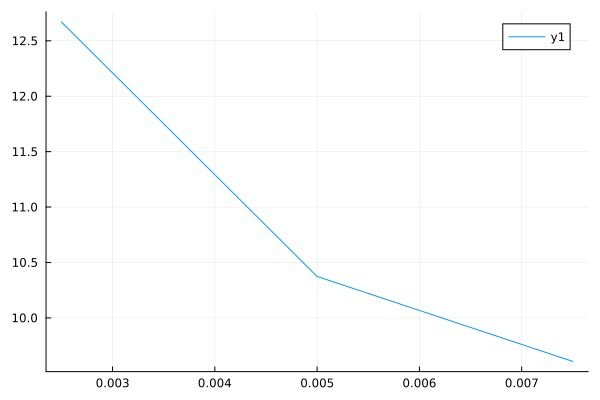

In [34]:
#relative error 
ideal_list = [2*i/(1+4*i) for i=0:0.0025:0.0075]
rel_error = 100 .* (ideal_list[2:end] .- real(g34_list10[1:end]))./ideal_list[2:end]
plot([0.0025:0.0025:0.0075;], rel_error)

In [35]:
rel_error

3-element Vector{Float64}:
 12.669790795723255
 10.373556942453709
  9.607185980531302

In [232]:
prob_test = ODEProblem(dx, 0.1, (0,5))
sol = solve(prob_test, saveat=cumsum(list_t))

retcode: Success
Interpolation: 1st order linear
t: 7-element Vector{Float64}:
 0.0
 0.023787176019345987
 0.0898170419682707
 0.26101793451240834
 0.6789993898990099
 1.6469579859738244
 3.7884277896807528
u: 7-element Vector{Float64}:
 0.1
 0.2398597509195167
 0.43542176370697744
 0.72937901101907
 1.1695988254436376
 1.8176541929302128
 2.7544182327344866

# 
---

# Diff eqn test

In [81]:
no_cavs = 2
sys_sites = siteinds("Qudit", no_cavs+1, dim=3)
input_list = repeat(["Ground",],no_cavs+1)
input_list[1] = "Excite1"
sys = MPO(sys_sites, input_list)

#Generating G2
gamma = 1
t_final = 10
depha = 0

g_f = g2_(gamma, depha, t_final, dt/2, no_cavs)
println("genfunctions")

p = (sys_sites, g_f, sqrt(gamma), depha)
prob = ODEProblem(drho3, sys, (0.0,t_final), p)

genfunctions


┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /Users/ygup3491/.julia/packages/SciMLBase/2HZ5m/src/performance_warnings.jl:32


ODEProblem with uType MPO and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: MPO
[1] ((dim=3|id=501|"Qudit,Site,n=1")', (dim=3|id=501|"Qudit,Site,n=1"), (dim=1|id=742|"Link,l=1"))
[2] ((dim=3|id=289|"Qudit,Site,n=2")', (dim=3|id=289|"Qudit,Site,n=2"), (dim=1|id=131|"Link,l=2"), (dim=1|id=742|"Link,l=1"))
[3] ((dim=3|id=479|"Qudit,Site,n=3")', (dim=3|id=479|"Qudit,Site,n=3"), (dim=1|id=131|"Link,l=2"))


In [82]:
prob2 = ODEProblem(dmpo_test!, sys, (0.0,t_final), p)

ODEProblem with uType MPO and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: MPO
[1] ((dim=3|id=501|"Qudit,Site,n=1")', (dim=3|id=501|"Qudit,Site,n=1"), (dim=1|id=742|"Link,l=1"))
[2] ((dim=3|id=289|"Qudit,Site,n=2")', (dim=3|id=289|"Qudit,Site,n=2"), (dim=1|id=131|"Link,l=2"), (dim=1|id=742|"Link,l=1"))
[3] ((dim=3|id=479|"Qudit,Site,n=3")', (dim=3|id=479|"Qudit,Site,n=3"), (dim=1|id=131|"Link,l=2"))


In [79]:
function dmpo_test!(drho, rho, p, t)
    sites = p[1]
    drho .= 0* MPO(sites, "I")
    
end

dmpo_test! (generic function with 1 method)

In [ ]:
function get_sites(mpo_i)
    no_sites = length(mpo_i)
    site_list = [;]
    for i=1:no_sites-1
        println(uniqueinds(mpo_i[i], mpo_i[i+1]))
        append!( site_list, uniqueinds(mpo_i[i], mpo_i[i+1]))
    end
    noprime!(site_list)
    union!(site_list)
    return site_list
end

In [77]:
function ITensors.oneunit(mpo_i::MPO)
    mpo_sites = siteinds(mpo_i)
    site_list = Index{Int64}[;]
    for i in mpo_sites
        plev(i[1]) == 0 ? push!(site_list, i[1]) : push!(site_list, i[2])
    end
    iden_mpo = MPO(site_list, "I")
    return iden_mpo
end

In [100]:
g34_list10

5-element Vector{Any}:
 0.004456372553084757 + 6.8661973589071875e-12im
 0.009212752913508215 + 3.0330706532980973e-9im
 0.014052481148312554 - 4.686498151937339e-10im
 0.018977736501179093 + 1.453050723863959e-9im
 0.024000385345919372 + 1.8609515342444433e-9im

In [101]:
a = [3,5,6]

3-element Vector{Int64}:
 3
 5
 6

In [104]:
a

3-element Vector{Int64}:
 3
 5
 6

In [103]:
append!([0,], a)

4-element Vector{Int64}:
 0
 3
 5
 6

In [78]:
oneunit(sys)

MPO
[1] ((dim=3|id=64|"Qudit,Site,n=1")', (dim=3|id=64|"Qudit,Site,n=1"), (dim=1|id=96|"Link,l=1"))
[2] ((dim=3|id=355|"Qudit,Site,n=2")', (dim=3|id=355|"Qudit,Site,n=2"), (dim=1|id=133|"Link,l=2"), (dim=1|id=96|"Link,l=1"))
[3] ((dim=3|id=714|"Qudit,Site,n=3")', (dim=3|id=714|"Qudit,Site,n=3"), (dim=1|id=133|"Link,l=2"))


In [ ]:
typeof(sys)

In [85]:
import Base.oneunit

In [94]:
function oneunit(a::Type{Any})
    if typeof(a) == MPO
        return oneunit(a)
    else
        println(a)
        throw("what")
    end
end

oneunit (generic function with 34 methods)

In [96]:
sol = solve(prob2)

Any


String: "what"

# Metal GPU speedup

In [ ]:
    #creating initial state and sites
    no_cavs = 2
    sys_sites = siteinds("Qudit", no_cavs+1, dim=3)
    input_list = repeat(["Ground",],no_cavs+1)
    input_list[1] = "Excite1"
    sys = MPO(sys_sites, input_list)
    met_sys = mtl(sys)

In [ ]:
#sparse matrices in julia are in Float64, GPU works on Float32

In [ ]:
mtl(op("I", sys_sites[1]))

In [ ]:
del = ITensor(identity(3), sys_sites[1], sys_sites[1]')

In [ ]:
ITensor([[1,2,3],[3,4,5]]; dtype=Float32)

In [ ]:
swapprime(met_sys[1], 1, 0)

In [ ]:
a = ITensor(met_sys[1])

# checking fidelity reversed 

In [ ]:
fidelity_list =  [;]
self_fidelity_list =  [;]
expect_list = [;]
gamma = 1
no_cavs = 2
dt = 0.02
t_final = 10
depa = 0:0.001:0.1

# for dep in depa
    
#     mpo, sites = create_MPO(no_cavs, dep, gamma, dt, t_final)
#     mpo2, sites2 = create_MPO(no_cavs, dep, gamma, dt, t_final; sites_provided = sites, reverse=true)

#     swapinds!(mpo2[end], sites[end], sites[1])
#     swapinds!(mpo2[end], sites[end]', sites[1]')
#     swapinds!(mpo2[1], sites[2], sites[end])
#     swapinds!(mpo2[1], sites[2]', sites[end]')
#     swapinds!(mpo2[end], sites[1], sites[2])
#     swapinds!(mpo2[end], sites[1]', sites[2]')

#     # swapinds!(mpo2[end-1], sites[end-1], sites[1])
#     # swapinds!(mpo2[end-1], sites[end-1]', sites[1]')
#     # swapinds!(mpo2[2], sites[3], sites[end-1])
#     # swapinds!(mpo2[2], sites[3]', sites[end-1]')
#     # swapinds!(mpo2[end-1], sites[1], sites[3])
#     # swapinds!(mpo2[end-1], sites[1]', sites[3]')


#     row = combiner(sites[2:end], tags="row")
#     ri = combinedind(row)
#     column = combiner(sites[2:end]', tags="column")
#     ci = combinedind(column)

#     ρ = row * prod(mpo) * column
#     ρ = Matrix(ρ, ri, ci)

#     σ = row * prod(mpo2) * column
#     σ = Matrix(σ, ri, ci)
#     σ_2 = σ ^ 0.5

#     push!(fidelity_list, tr(((σ_2) * ρ * (σ_2) ) ^0.5))
#     push!(self_fidelity_list, tr(((σ_2) * σ * (σ_2) ) ^0.5))
#     push!(expect_list, norm(ITensors.expect(mpo, sites[2:end])-ITensors.expect(mpo2, sites[2:end])))
# end
# # mpo, sites = create_MPO(no_cavs, dep, gamma, dt, t_final)
# 0


In [ ]:
var_list = [;]
for dep in depa
    push!(var_list, var(g2_(gamma, dep, t_final, dt, 20; reverse=false)))
end

In [ ]:
# plot(var_list)
plot(g2_(gamma, 1, t_final, dt, 20))

In [ ]:
var(g2_(gamma, 1, t_final, dt, 20))

In [ ]:
gv = g2_(gamma, 0, 10, dt, 4; reverse=false)
0

In [ ]:
plot(gv[1].([0:dt:t_final;]))

In [ ]:
# concern is that swap is not super accurate
# also can look at change in expectation value
# cuurently just exchanging indices

# just unrelated, should prob do many to one as opposed to bus

In [ ]:
#zeroth case sucks

In [ ]:
import Statistics

In [ ]:
var([1,2,0.0])

In [ ]:
p=plot(depa, real(fidelity_list), title="2 Cavs switched ", layout = (2,1), label="fidelity switch", seriestype="scatter")
plot!(depa, real(self_fidelity_list), label="ideal", seriestype="scatter")
plot!(depa, expect_list, subplot=2, label="difference norm", xlabel="Dephasing", seriestype="scatter")
# Plots.pdf(p, "fidelity_check_2cav_fine.pdf")
# xlabel!("Dephasing")
# title!("2 Cav switch")

In [ ]:
dep = 0.0001
no_cavs = 2
dt = 0.01
mpo, sites, expect = create_MPO(no_cavs, dep, gamma, dt, t_final)
mpo2, sites2, expect2 = create_MPO(no_cavs, dep, gamma, dt, t_final; sites_provided = sites, reverse=true)

In [ ]:
expect[end,2] - expect2[end,3]

In [ ]:
plot(expect[:,1])
plot!(expect[:,2])
plot!(expect2[:,3])

# Cavity Beamsplitter

In [ ]:
g34_list6 =  [;]
gamma = 1
no_cavs = 10
dt = 0.02
t_final = 10
for dep=0.0025:0.0025:0.0025
    #println(dep)
    mpo, sites = create_MPO(no_cavs, dep, gamma, dt, t_final)
    #println(ldl_lidt[end])
    # println(ITensors.expect(mpo, sites))
    double, double_sites = n_copy_mpo(2, mpo, sites)
    #println(sum(ITensors.expect(double, double_sites)))
    #normalize!(double)
    for i=1:no_cavs
        beamsplitter!(double, i, i+no_cavs, double_sites)
        #println(tr(double))
    end
    push!(g34_list6, g_34(double, double_sites, no_cavs))
end

In [ ]:
g34_list6 =  [;]
gamma = 1
no_cavs = 5
dt = 0.02
t_final = 10
mpo, sites = create_MPO(no_cavs, 0.005, gamma, dt, t_final)
double, double_sites = n_copy_mpo(2, mpo, sites)
for i=1:no_cavs
    @btime beamsplitter!(double, $i, $i+no_cavs, double_sites)
    #println(tr(double))
end

In [ ]:
g34_list6 =  [;]
gamma = 1
no_cavs = 5
dt = 0.02
t_final = 10
mpo, sites = create_MPO(no_cavs, 0.005, gamma, dt, t_final)
double, double_sites = n_copy_mpo(2, mpo, sites)
for i=1:no_cavs
    @btime beamsplitter_tensor!(double, $i, $i+no_cavs, double_sites)
    #println(tr(double))
end

In [ ]:
jldsave("g3.jld2"; g34_list3)

In [ ]:
f = jldopen("g5.jld2", "r")
g34_list5 = f["g34_list5"]
close(f)
f = jldopen("g5_pt2.jld2", "r")
g34_list5_2 = f["g34_list5"]
close(f)
f = jldopen("g8.jld2", "r")
g34_list8 = f["g34_list8"]
close(f)
f = jldopen("g3.jld2", "r")
g34_list3 = f["g34_list3"]
close(f)

In [ ]:
plot([0:0.0025:0.03;][1:11], [real(g34_list8)]; seriestype="scatter", label="Simulated 8")
plot!([0:0.0025:0.03;][1:11], [real(g34_list8)]; label="")

plot!([0:0.0025:0.03;], [real(g34_list5)]; seriestype="scatter", label="Simulated 5")
plot!([0:0.0025:0.03;], [real(g34_list5)]; label="")

# plot!([0:0.0025:0.0025;], [real(g34_list5_2)]; seriestype="scatter", label="Simulated 5 new")
# plot!([0:0.0025:0.0025;], [real(g34_list5_2)]; label="")

#plot!([0:0.0025:0.02;], [real(g34_list2)], label="")
plot!([0:0.0025:0.03;], [2*i/(1+4*i) for i=0:0.0025:0.03], label="ideal")
xlabel!("Dephasing")
ylabel!("Distinguishability")

In [ ]:
plot([0:0.0025:0.03;][1:11], (ideal_list[1:11]-real(g34_list8)); seriestype="scatter", label="Simulated 8")


plot!([0:0.0025:0.03;], (ideal_list-real(g34_list5)); seriestype="scatter", label="Simulated 5")

ylabel!("Absolute error")

In [ ]:
plot([0:0.0025:0.03;][1:11], (ideal_list[1:11]-real(g34_list8))./ideal_list[1:11]; label="Simulated 8")


plot!([0:0.0025:0.03;], (ideal_list-real(g34_list5))./ideal_list;  label="Simulated 5")

ylabel!("Relative error")

# Checking Bond Dim change with Beamsplitter

- Normalise doesn't reduce bond dimension
-Can use zip up in apply, i think automatically reduces the bond dim vs doing naive and putting truncate true, which still didnt get to min bond d
- Addition doesnt affect bond dim, (automatically reduced)
- naively using apply in the evolution loop wasn't blowing up the bond dim to something absurd (max was around 27 or 21, and mostly stayed around 10) but maybe using zip up will make it better 
- normalise doesnt do much for mpos, avoid


current to do : check negative case see when happ, recreate with atom, compare to analytic
change code to do apply differently, add garbage collection, make sure im making appropriate copies
make an alt gpu code

30/4/24
~ error in atoms evolution is like 10^-10, but the error in the cavitites is way higher , 10^-3 it is 10^-4 for empty cavities, g2 improve doesnt help that much, as compared to time step. 

In [ ]:
later: convergence

In [ ]:
function svdize!(mpo_i, sites_i)
    for i=1:length(sites_i)-1
        mul_term = mpo_i[i] * mpo_i[i+1]
        if i==1
            mpo_i[i], mpo_i[i+1] = qr(mul_term,(sites_i[i],sites_i[i]') )
        else
            mpo_i[i], mpo_i[i+1] = qr(mul_term,(sites_i[i],sites_i[i]',commonind(mpo_i[i-1], mpo_i[i])) )
        end
    end
end

# Dephasing cavities graph

In [ ]:
no_cav_needed_999 = [;]
no_cav_needed_9999 = [;]

for i=0:0.00001:0.02
    dt = 0.01
    gamma = 1
    t_fin = 10
    eigenvals =  g2_(gamma, i, t_fin, dt, 20)
    eigenvals /= sum(eigenvals)
    eigenvals = cumsum(eigenvals)
    push!(no_cav_needed_999, findall(>(0.999), eigenvals)[1])
    push!(no_cav_needed_9999, findall(>(0.9995), eigenvals)[1])
end

In [ ]:
p = plot(0:0.001:2, no_cav_needed_999, linetype=:steppre, label="99.9% Capture", linewidth=3)
plot!(0:0.001:2, no_cav_needed_9999, linetype=:steppre, label="99.95% Capture", linewidth=3)
ylabel!("Cavities")
xlabel!("Dephasing (% of γ)")
plot!(title="Cavities needed to capture Photon Wavefuntion")
Plots.pdf(p, "cav_needed.pdf")

In [ ]:
dt = 0.01
gamma = 1
t_fin = 10
eigenvals =  g2_(gamma, 0, t_fin, dt, 20)

In [ ]:
sum(eigenvals)

In [ ]:
findall(>(6), eigenvals)